## Orthogonal Collocation on Finite Elements

Discretization of a continuous time representation allow large-scale nonlinear programming (NLP) solvers to find solutions at specified intervals in a time horizon. There are many names and related techniques for obtaining mathematical relationships between derivatives and non-derivative values. Some of the terms that are relevant to this discussion include orthogonal collocation on finite elements, direct transcription, Gauss pseudospectral method, Gaussian quadrature, Lobatto quadrature, Radau collocation, Legendre polynomials, Chebyshev polynomials, Jacobi polynomials, Laguerre polynomials, any many more. There are many papers that discuss the details of the derivation and theory behind these methods1-5. The purpose of this section is to give a practical introduction to orthogonal collocation on finite elements with Lobatto quadrature for the numerical solution of differential algebraic equations. See the documentation on [Nodes](https://apmonitor.com/wiki/index.php/Main/OptionApmNodes) for additional details on displaying the internal nodes and the [course page on Orthogonal Collocation](https://apmonitor.com/do/index.php/Main/OrthogonalCollocation) for additional examples.

<img src='https://apmonitor.com/wiki/uploads/Main/nodes.png'>

### Solving with Gekko Automated Collocation

Solve the equation with NODES=4 at time points [0,1,2,3]:

$\frac{dy}{dt}=-y$

with initial condition $y_0=5$. Show the internal node solutions.

In [5]:
import pyomo.environ as pyo
from pyomo.dae import DerivativeVar, ContinuousSet

import numpy as np
import matplotlib.pyplot as plt

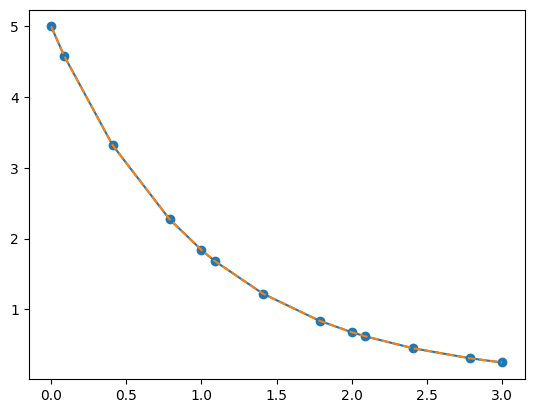

In [14]:
model = pyo.ConcreteModel()
model.t = ContinuousSet(bounds=(0, 3))

model.y = pyo.Var(model.t)
model.ydot = DerivativeVar(model.y, wrt=model.t)

model.init_cond = pyo.Constraint(expr=model.y[0] == 5)

def _ode(m, t):
    return m.ydot[t] == -m.y[t]
model.ode = pyo.Constraint(model.t, rule=_ode)

model.obj = pyo.Objective(expr=model.y[3], sense=pyo.minimize)

discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(model, nfe=3, ncp=4, scheme='LAGRANGE-RADAU')

solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=False)

t = np.array([t for t in model.t])
y = np.array([pyo.value(model.y[t]) for t in model.t])
plt.plot(t, y, marker='o')

analytic_y = 5 * np.exp(-t)

plt.plot(t, analytic_y, linestyle='--')


### Solving without Gekko Automated Collocation

Repeat the solution with NODES=4 using Orthogonal Collocation on Finite Elements but only for the first time interval [0,1]:

$\frac{dy}{dt}=-y$

with initial condition $y_0=5$. Show the node solutions.

Use the matrix `NC` and collocation `time` points as shown in the APMonitor [journal article](https://www.sciencedirect.com/science/article/pii/S0098135414001306) or [preprint](https://apmonitor.com/wiki/uploads/Main/APMonitor_2014.pdf).

```python
import numpy as np

N = np.array([[0.436,-0.281, 0.121], \
              [0.614, 0.064, 0.0461], \
              [0.603, 0.230, 0.167]])

time = np.array([0.0, \
                 0.5-np.sqrt(5)/10.0, \
                 0.5+np.sqrt(5)/10.0, \
                 1.0])
```

#### Reference

* Hedengren, J. D. and Asgharzadeh Shishavan, R., Powell, K.M., and Edgar, T.F., Nonlinear Modeling, Estimation and Predictive Control in APMonitor, Computers and Chemical Engineering, Volume 70, pg. 133–148, 2014, doi: 10.1016/j.compchemeng.2014.04.013

# MY NOTES:

We have $x_0$ given as the initial condition.

We then have three points at which $x_i$ and $\dot{x}_i$ is not known.

There should be some way to relate the derivative at each point as it relates to each non-derivative.

$$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3\end{bmatrix} = M \left(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix} - \begin{bmatrix}x_0 \\ x_0 \\ x_0\end{bmatrix} \right)$$

We then seek to approximate the solution as a polynomial. Since there are three unknown points and we already know the initial condition, this would be a third-order polynomial

$$x(t) = A + Bt + Ct^2 + Dt^3$$

Which is easy to find the derivative of:

$$\dot{x}(t) = B + 2Ct + 3Dt^2$$

Subbing these back into the matrix equation, we get this:

$$\begin{bmatrix} B + 2Ct_1 + 3Dt_1^2 \\ B + 2Ct_2 + 3Dt_2^2 \\ B + 2Ct_3 + 3Dt_3^2 \end{bmatrix} = M \left( \begin{bmatrix} A + Bt_1 + Ct_1^2 + Dt_1^3 \\ A + Bt_2 + Ct_2^2 + Dt_2^3 \\ A + Bt_3 + Ct_3^3 + Dt_3^3  \end{bmatrix} - \begin{bmatrix} A + Bt_0 + Ct_0^2 + Dt_0^3 \\ A + Bt_0 + Ct_0^2 + Dt_0^3 \\ A + Bt_0 + Ct_0^3 + Dt_0^3  \end{bmatrix} \right)$$

Arbitrarily defining $t_0 = 0$, we get the following.

$$\begin{bmatrix} B + 2Ct_1 + 3Dt_1^2 \\ B + 2Ct_2 + 3Dt_2^2 \\ B + 2Ct_3 + 3Dt_3^2 \end{bmatrix} = M \begin{bmatrix} Bt_1 + Ct_1^2 + Dt_1^3 \\ Bt_2 + Ct_2^2 + Dt_2^3 \\ Bt_3 + Ct_3^3 + Dt_3^3  \end{bmatrix} $$

Which can then be simplified.

$$\begin{bmatrix} 1 & 2t_1 & 3t_1^2 \\ 1 & 2t_2 & 3t_2^2 \\ 1 & 2t_3 & 3t_3^2 \end{bmatrix} \begin{bmatrix}B \\ C \\ D \end{bmatrix} = M \begin{bmatrix} t_1 & t_1^2 & t_1^3 \\ t_2 & t_2^2 & t_2^3 \\ t_3 & t_3^3 & t_3^3  \end{bmatrix}  \begin{bmatrix}B \\ C \\ D \end{bmatrix}$$

Which can then be simplified.

$$\begin{bmatrix} 1 & 2t_1 & 3t_1^2 \\ 1 & 2t_2 & 3t_2^2 \\ 1 & 2t_3 & 3t_3^2 \end{bmatrix} = M \begin{bmatrix} t_1 & t_1^2 & t_1^3 \\ t_2 & t_2^2 & t_2^3 \\ t_3 & t_3^3 & t_3^3  \end{bmatrix}$$

Given $t_1$, $t_2$, and $t_3$, we can then solve this equation to find the appropriate $M$ matrix to use. Note that this will be appropriate regardless of what the actual values of $B$, $C$, and $D$ are.

Let's go ahead and find $M$ for this problem.

In [17]:
t = np.linspace(0, 1, 4)

LHS = np.array([[1, 2*t[1], 3*t[1]**2],
                [1, 2*t[2], 3*t[2]**2],
                [1, 2*t[3], 3*t[3]**2]])

RHS = np.array([[t[1], t[1]**2, t[1]**3],
                [t[2], t[2]**2, t[2]**3],
                [t[3], t[3]**2, t[3]**3]])

M = LHS @ np.linalg.inv(RHS)

print("M =")
print(M)

M =
[[-1.5  3.  -0.5]
 [-3.   1.5  1. ]
 [ 4.5 -9.   5.5]]


Now we want to actually solve the problem.

We have 6 unknowns: $x_1, x_2, x_3, \dot{x}_1, \dot{x}_2, \dot{x}_3$

By this point we have 3 equations (with our known $M$ and $x_0$)

$$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3\end{bmatrix} = M \left(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix} - \begin{bmatrix}x_0 \\ x_0 \\ x_0\end{bmatrix} \right)$$

We need 3 more equations.

From the original ODE, we have $\dot{x}_i = -x_i$

Which gives us our other three equations.

In [11]:
from scipy.optimize import fsolve

x1, x2, x3, dx1, dx2, dx3 =
[ 3.59223301  2.57281553  1.84466019 -3.59223301 -2.57281553 -1.84466019]


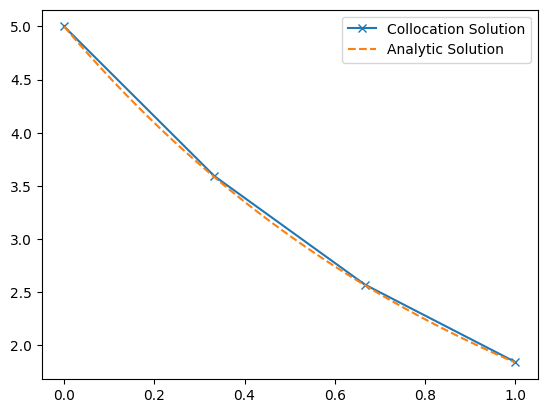

In [19]:
x0 = 5

def SolveMe(vars):
    x1, x2, x3, dx1, dx2, dx3 = vars

    # I could write this in matrix form, but it's probably clearer like this

    eq1 = dx1 - (M[0,0]*(x1-x0) + M[0,1]*(x2-x0) + M[0,2]*(x3-x0))
    eq2 = dx2 - (M[1,0]*(x1-x0) + M[1,1]*(x2-x0) + M[1,2]*(x3-x0))
    eq3 = dx3 - (M[2,0]*(x1-x0) + M[2,1]*(x2-x0) + M[2,2]*(x3-x0))
    eq4 = dx1 + x1
    eq5 = dx2 + x2
    eq6 = dx3 + x3

    return [eq1, eq2, eq3, eq4, eq5, eq6]

ans = fsolve(SolveMe, [4, 3, 2, -4, -3, -2])
print("x1, x2, x3, dx1, dx2, dx3 =")
print(ans)

x = np.array([x0, ans[0], ans[1], ans[2]])

plt.plot(t, x, marker='x', label='Collocation Solution')

fine_t = np.linspace(0, 1, 100)
analytic_y = 5 * np.exp(-fine_t)
plt.plot(fine_t, analytic_y, linestyle='--', label='Analytic Solution')
plt.legend()